In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from core import med_log_odds_cutoff, high_log_odds_cutoff, bw_color_palette
from textwrap import fill
from tqdm import tqdm

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7

In [4]:
def select_domains(hhblits_df, prob_cutoff=50):
    # Other Domains
    out_list = []
    for group, group_df in tqdm(hhblits_df[(hhblits_df['Prob'] > prob_cutoff)].groupby('query'), 
                                position=0, total=hhblits_df['query'].nunique()):
        group_df = group_df.sort_values('Prob', ascending=False)
        while len(group_df):
            selected_row = group_df.head(1).squeeze()
            out_list.append(selected_row)
            group_df = group_df[(group_df['qend'] < selected_row['qstart']) |
                                (group_df['qstart'] > selected_row['qend'])]
    selected_domain_df = pd.concat(out_list, axis=1).T
    return selected_domain_df

In [5]:
def assign_hit_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    elif row['q_cov'] > 0.5:
        return 'Remote defense homolog'
    else:
        return 'Predicted novel defense gene'

In [6]:
predictions = pd.read_csv('../data/interim/ecor_predictions.csv')
hhpred_results = pd.read_csv('../data/interim/ecor_putative_novel_pfam_df_domains.csv')
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', 
                           names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])

/state/partition1/slurm_tmp/27709726.0.0/ipykernel_3956337/587451521.py:1: DtypeWarning: Columns (21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  predictions = pd.read_csv('../data/interim/ecor_predictions.csv')


In [93]:
predictions[['assembly']].drop_duplicates().to_csv('../data/processed/ecor_assemblies.csv', index=False)

In [7]:
blacklisted_domains = pd.read_csv('../data/interim/df_blacklisted_domains.csv')

In [8]:
pos_training_df = pd.read_parquet('../data/interim/defense_finder_model_seqs.pq')

In [9]:
pos_train_genes = pos_training_df.loc[(pos_training_df['split'] == 'train'), 'protein_accession']
pos_train_profiles = pos_training_df.loc[pos_training_df['split'] == 'train', 'gene_name'].drop_duplicates().to_list()

In [10]:
def search_for_profile(names, train_names=pos_train_profiles):
    if pd.isna(names):
        return False
    else: 
        for name in names.split(', '):
            if name in train_names:
                return True
        return False

In [11]:
predictions['log_odds'] = np.log(predictions['beaker_prediction']/(1-predictions['beaker_prediction']))
predictions['pos_training_protein'] = predictions['product_accession'].isin(pos_train_genes)
predictions['pos_training_profile'] = predictions['defense_homolog_names'].apply(search_for_profile)

In [12]:
non_train_df_hits = predictions[predictions['defense_system_protein'] & ~predictions['pos_training_profile']]

In [13]:
non_train_df_hits.sort_values('log_odds')

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,defense_system_protein,defense_homolog_names,sys_id,operon,contig_end,cluster_id,MG1655_homolog,log_odds,pos_training_protein,pos_training_profile
264374,WP_001443175.1|NZ_QOYO01000010.1|92396|+,7.249310e-08,CDS,with_protein,GCF_003333605.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYO01000010.1,92396,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_QOYO01000010.1|90393|+,False,WP_011310318.1,False,-16.439774,False,False
264379,WP_001443175.1|NZ_RRWG01000011.1|99748|-,7.337144e-08,CDS,with_protein,GCF_003886445.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRWG01000011.1,99748,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_RRWG01000011.1|99748|-,False,WP_011310318.1,False,-16.427731,False,False
264377,WP_001443175.1|NZ_RRVB01000005.1|99901|-,7.631244e-08,CDS,with_protein,GCF_003886535.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRVB01000005.1,99901,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_RRVB01000005.1|99901|-,False,WP_011310318.1,False,-16.388430,False,False
264380,WP_001443175.1|NZ_RRWH01000005.1|123768|+,7.655658e-08,CDS,with_protein,GCF_003886455.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRWH01000005.1,123768,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_RRWH01000005.1|121765|+,False,WP_011310318.1,False,-16.385236,False,False
264378,WP_001443175.1|NZ_RRVU01000004.1|221233|+,7.719961e-08,CDS,with_protein,GCF_003892355.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRVU01000004.1,221233,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_RRVU01000004.1|219230|+,False,WP_011310318.1,False,-16.376871,False,False
264376,WP_001443175.1|NZ_QOYW01000008.1|108838|-,8.288294e-08,CDS,with_protein,GCF_003334525.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYW01000008.1,108838,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_QOYW01000008.1|108838|-,False,WP_011310318.1,False,-16.305837,False,False
264375,WP_001443175.1|NZ_QOYQ01000019.1|20667|-,1.081967e-07,CDS,with_protein,GCF_003334555.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYQ01000019.1,20667,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_QOYQ01000019.1|20667|-,False,WP_011310318.1,False,-16.039315,False,False
264381,WP_001443175.1|NZ_RRWO01000003.1|99901|-,1.195934e-07,CDS,with_protein,GCF_003886695.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRWO01000003.1,99901,...,True,"ShosTA__ShosA, PsyrTA__PsyrA",UserReplicon_PsyrTA_1,NZ_RRWO01000003.1|99901|-,False,WP_011310318.1,False,-15.939168,False,False
168040,WP_244558146.1|NZ_QOWY01000101.1|155|+,1.508668e-01,CDS,with_protein,GCF_003334235.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOWY01000101.1,155,...,True,PD-T4-3__PD-T4-3,UserReplicon_PD-T4-3_1,NZ_QOWY01000101.1|155|+,True,WP_033870691.1,False,-1.727819,False,False
316239,WP_001104341.1|NZ_RRWG01000032.1|1628|+,3.192871e-01,CDS,with_protein,GCF_003886445.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRWG01000032.1,1628,...,True,SoFic__SoFic,UserReplicon_SoFic_2,NZ_RRWG01000032.1|1628|+,False,WP_001104341.1,False,-0.757050,False,False


In [14]:
non_train_df_hits['defense_homolog_names'].value_counts()

defense_homolog_names
PD-T4-3__PD-T4-3                12
ShosTA__ShosA, PsyrTA__PsyrA     8
Rst_PARIS__DUF4435               3
AbiEii__AbiEii                   3
SoFic__SoFic                     2
PD-T4-9__PD-T4-9_A               1
PD-T4-2__PD-T4-2_B               1
PD-Lambda-2__PD-Lambda-2_A       1
AbiV__AbiV                       1
Name: count, dtype: int64

In [15]:
(non_train_df_hits['log_odds'] > med_log_odds_cutoff).sum()

17

In [16]:
len(non_train_df_hits)

32

In [17]:
total_pred = len(predictions)
print('Total # genes', total_pred)
g_p5 = (predictions['beaker_prediction'] > 0.5).sum()
print('# Genes with P > 0.5', g_p5)
print('Frac genes with P > 0.5', round(g_p5/total_pred, 3))
g_cutoff = (predictions['log_odds'] > med_log_odds_cutoff).sum()
print('# genes with LO >', round(med_log_odds_cutoff, 3), g_cutoff)
print('frac. genes with LO >', round(med_log_odds_cutoff, 3), round(g_cutoff/total_pred, 3))


Total # genes 321347
# Genes with P > 0.5 4603
Frac genes with P > 0.5 0.014
# genes with LO > 7.171 2493
frac. genes with LO > 7.171 0.008


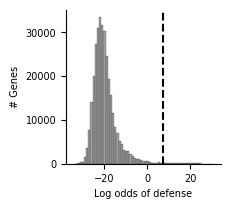

In [18]:
plt.subplots(figsize=(2,2))
sns.histplot(predictions['log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hit_distribution.svg', dpi=300, bbox_inches='tight')

In [19]:
filtered_predictions = predictions[predictions['log_odds'] > med_log_odds_cutoff].copy()
filtered_predictions['accession_stub'] = (filtered_predictions['product_accession']
                                          .str.split('.', expand=True)[0])

In [20]:
hhpred_results['q_ali_len'] = hhpred_results['qend'] - hhpred_results['qstart']
remote_defense_homologs = (hhpred_results[hhpred_results['hit_name'].str.contains('~') &
                                          (hhpred_results['Prob'] > 50)]
                           .sort_values('q_ali_len', ascending=False)
                           .groupby('query')
                           .head(1)
                           .merge(filtered_predictions[['accession_stub', 'product_accession', 'product_length']].drop_duplicates(), 
                                  how='left', left_on='query', right_on='accession_stub'))
remote_defense_homologs['q_cov'] = remote_defense_homologs['q_ali_len']/remote_defense_homologs['product_length']


In [21]:
merged_predictions = (filtered_predictions.merge(
    remote_defense_homologs[['product_accession', 'hit_name', 'q_cov', 'Prob']], how='left', 
                                                   on='product_accession'))
merged_predictions['q_cov'] = merged_predictions['q_cov'].fillna(0)
merged_predictions['hit_category'] = merged_predictions.apply(assign_hit_category, axis=1)
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Remote defense homolog', 
                  'Predicted novel defense gene']
merged_predictions['hit_category'] = pd.Categorical(merged_predictions['hit_category'], 
                                                    categories=hit_categories)

In [22]:
merged_predictions['hit_category'].value_counts()/len(merged_predictions)

hit_category
Defense homolog in new context        0.525070
Predicted novel defense gene          0.243482
Defense homolog in expected system    0.130365
Remote defense homolog                0.101083
Name: count, dtype: float64

In [23]:
merged_predictions['hit_category'].value_counts()

hit_category
Defense homolog in new context        1309
Predicted novel defense gene           607
Defense homolog in expected system     325
Remote defense homolog                 252
Name: count, dtype: int64

In [24]:
merged_predictions['pos_training_profile'].isna().sum()

0

In [25]:
merged_predictions.loc[(merged_predictions['hit_category'] == 'Defense homolog in expected system') & 
                       (~merged_predictions['pos_training_profile'])]

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,cluster_id,MG1655_homolog,log_odds,pos_training_protein,pos_training_profile,accession_stub,hit_name,q_cov,Prob,hit_category
587,WP_000355484.1|NZ_QOWZ01000021.1|47176|+,0.999286,CDS,with_protein,GCF_003334705.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOWZ01000021.1,47176,...,WP_000353910.1,False,7.243362,False,False,WP_000355484,NaN,0.0,NaN,Defense homolog in expected system
588,WP_000355484.1|NZ_QOXX01000038.1|22510|+,0.999993,CDS,with_protein,GCF_003334605.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXX01000038.1,22510,...,WP_000353910.1,False,11.866419,False,False,WP_000355484,NaN,0.0,NaN,Defense homolog in expected system
589,WP_000355484.1|NZ_QOXY01000040.1|22510|+,0.999993,CDS,with_protein,GCF_003333855.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXY01000040.1,22510,...,WP_000353910.1,False,11.863463,False,False,WP_000355484,NaN,0.0,NaN,Defense homolog in expected system
590,WP_000355484.1|NZ_QOXZ01000045.1|22329|+,0.999993,CDS,with_protein,GCF_003333845.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXZ01000045.1,22329,...,WP_000353910.1,False,11.863463,False,False,WP_000355484,NaN,0.0,NaN,Defense homolog in expected system
591,WP_000355484.1|NZ_QOYA01000037.1|33192|+,0.999993,CDS,with_protein,GCF_003333795.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYA01000037.1,33192,...,WP_000353910.1,False,11.834717,False,False,WP_000355484,NaN,0.0,NaN,Defense homolog in expected system
592,WP_000355484.1|NZ_QOZA01000068.1|1828|+,0.999913,CDS,with_protein,GCF_003333425.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOZA01000068.1,1828,...,WP_000353910.1,False,9.348828,False,False,WP_000355484,NaN,0.0,NaN,Defense homolog in expected system
693,WP_001580542.1|NZ_QOXD01000001.1|102717|-,1.000000,CDS,with_protein,GCF_003334715.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXD01000001.1,102717,...,WP_001580542.1,False,23.101549,False,False,WP_001580542,NaN,0.0,NaN,Defense homolog in expected system
694,WP_001580542.1|NZ_QOZE01000013.1|4905|+,1.000000,CDS,with_protein,GCF_003334425.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOZE01000013.1,4905,...,WP_001580542.1,False,23.098718,False,False,WP_001580542,NaN,0.0,NaN,Defense homolog in expected system
839,WP_047085429.1|NZ_QOXJ01000032.1|18099|+,0.999613,CDS,with_protein,GCF_003334085.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXJ01000032.1,18099,...,WP_000365809.1,False,7.855497,False,False,WP_047085429,NaN,0.0,NaN,Defense homolog in expected system
1566,WP_001521912.1|NZ_QOYI01000014.1|42778|+,0.999988,CDS,with_protein,GCF_003333685.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYI01000014.1,42778,...,WP_000365809.1,False,11.336443,False,False,WP_001521912,NaN,0.0,NaN,Defense homolog in expected system


In [26]:
predictions['defense_system_protein'].sum()

395

In [27]:
predictions.loc[(predictions['log_odds'] <= med_log_odds_cutoff) & 
            (predictions['defense_system_protein']), 'defense_homolog_names'].value_counts()

defense_homolog_names
Mok_Hok_Sok__Hok                                          22
Shango__SngC, PsyrTA__PsyrT                                8
ShosTA__ShosA, PsyrTA__PsyrA                               8
PD-T4-1__PD-T4-1                                           6
PD-T4-3__PD-T4-3                                           4
Gabija__GajB_3, Gabija__GajB_2, Gabija__GajB_1             3
PD-Lambda-5__PD-Lambda-5_B, RM_Type_II__Type_II_MTases     3
BREX__brxHII, DISARM_1__drmD                               2
SoFic__SoFic                                               2
CBASS__Phospholipase                                       2
BstA__BstA                                                 2
PD-Lambda-6__PD-Lambda-6                                   1
BREX__pglW, Mokosh_TypeI__MkoA, PD-T4-6__PD-T4-6           1
Gabija__GajB_2                                             1
BREX__pglW, Mokosh_TypeI__MkoA2                            1
RM_Type_II__Type_II_MTases                                 1
PD

In [28]:
merged_predictions.loc[merged_predictions['hit_category'] == 'Defense homolog in new context', 
                       'defense_homolog_names'].value_counts().head(60)

defense_homolog_names
RM_Type_II__Type_II_MTases                                                                                                                                                                                                                                                                                                                                                                  85
Retron_I_B__ATPase_TOPRIM_COG3593, PARIS_I__AAA_15                                                                                                                                                                                                                                                                                                                                          68
RM__Type_I_S                                                                                                                                                                                                        

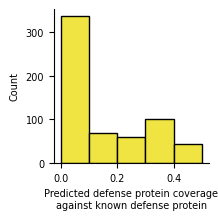

In [29]:
plt.subplots(figsize=(2,2))
sns.histplot(data=merged_predictions[merged_predictions['hit_category'] == 'Predicted novel defense gene'], 
             x='q_cov', binwidth=0.1, color='#f0e442', alpha=1)
plt.xlabel('Predicted defense protein coverage\nagainst known defense protein')
sns.despine()
plt.savefig('../figures/novel_coverage.svg', dpi=300, bbox_inches='tight')

In [30]:
no_defense_homology_df = merged_predictions.loc[~merged_predictions['defense_homolog'] & 
                                                 (merged_predictions['q_cov'] == 0),:]
no_defense_homology_df.to_csv('../data/interim/predicted_defense_no_homology_df.csv', index=False)

In [31]:
no_defense_homology_df['cluster_id'].nunique()

131

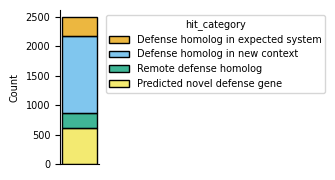

In [32]:
_, ax = plt.subplots(figsize=(0.5, 2))
ax = sns.histplot(data=merged_predictions, x=0, 
             hue='hit_category', 
             multiple='stack', 
             palette=bw_color_palette[:4], ax=ax, )
sns.move_legend(ax, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.xticks([])
plt.xlabel('')
plt.savefig('../figures/predicted_defense_known_frac.svg', dpi=300, bbox_inches='tight')

In [33]:
missing_dsp = predictions[predictions['defense_system_protein'] & 
                           ~predictions['protein_context_id'].isin(merged_predictions['protein_context_id'])].copy()
missing_dsp['hit_category'] = 'Defense homolog in expected system'
cat_merged_predictions = pd.concat([missing_dsp, merged_predictions])
hit_category_map = {cat: fill(cat, 20) for cat in hit_categories}
cat_merged_predictions['display_category'] = cat_merged_predictions['hit_category'].map(hit_category_map)
display_cat_order = list(hit_category_map.values())
cat_merged_predictions['display_category'] = pd.Categorical(cat_merged_predictions['display_category'], 
                                                            categories=display_cat_order)

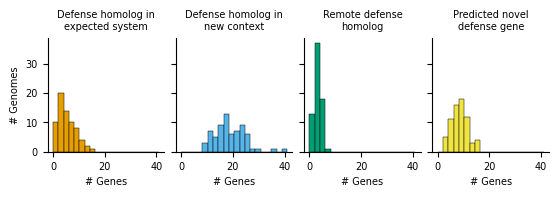

In [34]:
dp_per_genome = (cat_merged_predictions.groupby(['assembly', 'display_category'])
                 .agg(n_proteins=('product_accession', 'count'))
                 .reset_index())
g = sns.displot(data=dp_per_genome, x='n_proteins', binwidth=2, 
                hue='display_category', palette=(bw_color_palette[:4]), 
                col='display_category', kind='hist', facet_kws={'sharey': True}, 
                alpha=1, height=2, legend=False, aspect=0.7)
g.set_titles(template='{col_name}')
g.set_xlabels('# Genes')
g.set_ylabels('# Genomes')
g.figure.subplots_adjust(wspace=0.1)
plt.savefig('../figures/dp_per_genome.svg', bbox_inches='tight', dpi=300)

In [35]:
novel_accessions = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                          'product_accession'].drop_duplicates()
n_partial_align = remote_defense_homologs['product_accession'].isin(novel_accessions).sum()
print('# predicted novel defense genes with partial alignment:', n_partial_align)
print('Frac with partial alignment', n_partial_align/len(novel_accessions))

# predicted novel defense genes with partial alignment: 198
Frac with partial alignment 0.49624060150375937


In [36]:
pfam_results = hhpred_results[(hhpred_results['hit_name'].str[:2] == 'PF') & 
                              (hhpred_results['Prob'] > 50)].copy()
pfam_results['pfam_id'] = pfam_results['hit_name'].str.split('.', expand=True)[0]
pfam_results = pfam_results.merge(pfam_clans, how='left', on='pfam_id')

In [37]:
novel_accessions = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                          'accession_stub'].drop_duplicates()
novel_pfam_results = pfam_results[pfam_results['query'].isin(novel_accessions)]
novel_pfam_clans = (novel_pfam_results[['query', 'clan_name']]
                    .drop_duplicates())

In [38]:
select_novel_pfam_domains = select_domains(novel_pfam_results)

100%|██████████| 327/327 [00:00<00:00, 651.34it/s]


In [39]:
select_novel_pfam_known_domains = select_novel_pfam_domains[select_novel_pfam_domains['pfam_id'].isin(blacklisted_domains['pfam_id'])]

In [40]:
novel_genes_known_domains = merged_predictions.loc[(merged_predictions['hit_category'] == 'Predicted novel defense gene') & 
                                                   (merged_predictions['accession_stub'].isin(select_novel_pfam_known_domains['query']))]

In [41]:
len(novel_genes_known_domains)

346

In [42]:
(select_novel_pfam_domains[['query','pfam_name', 'clan_name']].drop_duplicates()
 [['pfam_name', 'clan_name']]
 .value_counts()
 .head(20))

pfam_name        clan_name    
IIGP             P-loop_NTPase    48
Dynamin_N        P-loop_NTPase    47
RepB-RCR_reg     Met_repress      16
Mrr_cat_2        PDDEXK           14
DpnII-MboI       PDDEXK            9
KAP_NTPase       P-loop_NTPase     5
NinG             His-Me_finger     5
BrxC_BrxD        P-loop_NTPase     4
DUF1887          PDDEXK            3
Hjc              PDDEXK            3
HATPase_c_5      His_Kinase_A      3
NERD             PDDEXK            3
NucS_C           PDDEXK            3
Nucleoporin_FG2  FG_rpt            3
NurA             RNase_H           3
PDDEXK_4         PDDEXK            3
pEK499_p136      KNTase_C          3
Response_reg_2   CheY              3
ATPase_2         P-loop_NTPase     3
SWI2_SNF2        P-loop_NTPase     3
Name: count, dtype: int64

In [43]:
novel_pfam_clan_count = (select_novel_pfam_domains.groupby('clan_name')
                         .agg(count=('query', 'nunique'))
                         .rename(index={'P-loop_NTPase': 'P-loop NTPase', 
                                        'PDDEXK': 'PDDEXK nuclease', 
                                        'PEP-carboxyk': 'PEP carboxykinase',
                                        'Met_repress': 'RHH antitoxin DNA binding', 
                                        'KNTase_C': 'HEPN', 
                                        'His-Me_finger': 'HNH endonuclease', 
                                        'Zn_Beta_Ribbon': 'Zinc finger', 
                                        'His_Kinase_A': 'His kinase phospho-acceptor'})
                         .sort_values('count', ascending=False)
                         .reset_index())
novel_pfam_clan_count['freq'] = novel_pfam_clan_count['count']/len(novel_accessions)

In [44]:
novel_pfam_clan_count

,clan_name,count,freq
0,P-loop NTPase,65,0.162907
1,PDDEXK nuclease,49,0.122807
2,RHH antitoxin DNA binding,16,0.040100
3,HEPN,12,0.030075
4,HNH endonuclease,8,0.020050
5,HTH,8,0.020050
6,His kinase phospho-acceptor,4,0.010025
7,PIN,4,0.010025
8,FG_rpt,3,0.007519
9,RNase_H,3,0.007519


In [45]:
select_novel_pfam_domains[select_novel_pfam_domains['clan_name'] == 'Met_repress']

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,query,qstart,qend,hit_name,q_ali_len,pfam_id,clan_id,clan_name,pfam_name,pfam_description
670,PF10723.12 ; RepB-RCR_reg ; Re,97.6,0.0,0.0,71.1,0.0,59.0,324-382,20-80 (81),WP_000068158,324.0,382.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,58.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
1373,PF10723.12 ; RepB-RCR_reg ; Re,98.1,0.0,0.0,73.5,0.0,61.0,225-287,20-80 (81),WP_000241617,225.0,287.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,62.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
3570,PF10723.12 ; RepB-RCR_reg ; Re,97.9,0.0,0.0,72.1,0.0,59.0,252-310,20-80 (81),WP_000290405,252.0,310.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,58.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
3591,PF10723.12 ; RepB-RCR_reg ; Re,97.9,0.0,0.0,71.5,0.0,59.0,252-310,20-80 (81),WP_000290406,252.0,310.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,58.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
3612,PF10723.12 ; RepB-RCR_reg ; Re,97.9,0.0,0.0,72.1,0.0,59.0,252-310,20-80 (81),WP_000290408,252.0,310.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,58.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
6341,PF10723.12 ; RepB-RCR_reg ; Re,97.8,0.0,0.0,70.9,0.0,60.0,204-263,20-80 (81),WP_000816117,204.0,263.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,59.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
9634,PF10723.12 ; RepB-RCR_reg ; Re,97.8,0.0,0.0,71.8,0.0,61.0,274-335,20-80 (81),WP_001330680,274.0,335.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,61.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
9955,PF10723.12 ; RepB-RCR_reg ; Re,97.8,0.0,0.0,71.8,0.0,61.0,274-335,20-80 (81),WP_001375310,274.0,335.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,61.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
10043,PF10723.12 ; RepB-RCR_reg ; Re,97.8,0.0,0.0,71.8,0.0,61.0,274-335,20-80 (81),WP_001403577,274.0,335.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,61.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB
10679,PF10723.12 ; RepB-RCR_reg ; Re,98.0,0.0,0.0,73.9,0.0,60.0,276-335,20-80 (81),WP_001528417,276.0,335.0,PF10723.12 ; RepB-RCR_reg ; Replication regula...,59.0,PF10723,CL0057,Met_repress,RepB-RCR_reg,Replication regulatory protein RepB


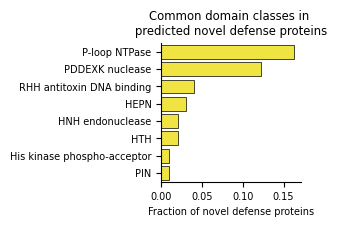

In [46]:
plt.subplots(figsize=(1.8,1.8))
sns.barplot(data=novel_pfam_clan_count.head(8), y='clan_name', x='freq', 
            color=bw_color_palette[3], linewidth=0.5, edgecolor='black', saturation=100)
sns.despine()
plt.xlabel('Fraction of novel defense proteins')
plt.ylabel('')
plt.title('Common domain classes in \npredicted novel defense proteins')
plt.savefig('../figures/predicted_novel_defense_domains.svg', dpi=300, bbox_inches='tight')

In [47]:
def assign_hit_category2(row, cutoff=med_log_odds_cutoff):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['log_odds'] > cutoff:
        if row['defense_homolog']:
            return 'Defense homolog in new context'
        elif row['q_cov'] > 0.5:
            return 'Remote defense homolog'
        else: 
            return 'Predicted novel defense gene'
    else:
        return 'Not defensive'

In [48]:
all_merged_predictions = (predictions.merge(
    remote_defense_homologs[['product_accession', 'hit_name', 'q_cov', 'Prob']], how='left', 
                                                   on='product_accession'))
all_merged_predictions['q_cov'] = all_merged_predictions['q_cov'].fillna(0)
all_merged_predictions['hit_category'] = all_merged_predictions.apply(assign_hit_category2, axis=1)
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Remote defense homolog', 
                  'Predicted novel defense gene', 
                  'Not defensive']
all_merged_predictions['hit_category'] = pd.Categorical(all_merged_predictions['hit_category'], 
                                                    categories=hit_categories)


In [47]:
all_merged_predictions.to_csv('../data/interim/ecor_predictions_defensive_cat.csv', index=False)


In [48]:
all_merged_predictions['hit_category'].value_counts()

hit_category
Not defensive                         318784
Defense homolog in new context          1309
Predicted novel defense gene             607
Defense homolog in expected system       395
Remote defense homolog                   252
Name: count, dtype: int64

### Redo these analyses, but only consider one gene per cluster

In [50]:
non_redundant_predictions = (all_merged_predictions
                             .sort_values(['hit_category', 'beaker_prediction'], ascending=[True, False])
                             .groupby('cluster_id')
                             .head(1))

In [51]:
non_redundant_predictions['hit_category'].value_counts()

hit_category
Not defensive                         13004
Defense homolog in new context          320
Predicted novel defense gene            235
Defense homolog in expected system      161
Remote defense homolog                   85
Name: count, dtype: int64

In [52]:
len(non_redundant_predictions)

13805

In [53]:
(non_redundant_predictions['beaker_prediction'] > 0.5).sum()

1208

In [54]:
non_train_df_hits = non_redundant_predictions[non_redundant_predictions['defense_system_protein'] & ~non_redundant_predictions['pos_training_profile']]

In [55]:
non_train_df_hits.sort_values('log_odds')

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,contig_end,cluster_id,MG1655_homolog,log_odds,pos_training_protein,pos_training_profile,hit_name,q_cov,Prob,hit_category
264381,WP_001443175.1|NZ_RRWO01000003.1|99901|-,1.195934e-07,CDS,with_protein,GCF_003886695.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRWO01000003.1,99901,...,False,WP_011310318.1,False,-15.939168,False,False,NaN,0.0,NaN,Defense homolog in expected system
316240,WP_001104341.1|NZ_RRWH01000040.1|20710|-,3.384355e-01,CDS,with_protein,GCF_003886455.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRWH01000040.1,20710,...,False,WP_001104341.1,False,-0.670274,False,False,NaN,0.0,NaN,Defense homolog in expected system
181499,WP_087898297.1|NZ_QOXH01000008.1|116077|+,3.551507e-01,CDS,with_protein,GCF_003334115.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXH01000008.1,116077,...,False,WP_087898297.1,False,-0.596475,False,False,NaN,0.0,NaN,Defense homolog in expected system
175206,WP_033870691.1|NZ_QOXC01000016.1|4199|+,9.043181e-01,CDS,with_protein,GCF_003334175.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXC01000016.1,4199,...,False,WP_033870691.1,False,2.246152,False,False,NaN,0.0,NaN,Defense homolog in expected system
310995,WP_023339286.1|NZ_RRVF01000054.1|2501|-,9.999466e-01,CDS,with_protein,GCF_003886115.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRVF01000054.1,2501,...,False,WP_023339286.1,False,9.838346,False,False,NaN,0.0,NaN,Defense homolog in expected system
251828,WP_001521912.1|NZ_QOYI01000014.1|42778|+,9.999881e-01,CDS,with_protein,GCF_003333685.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYI01000014.1,42778,...,False,WP_000365809.1,False,11.336443,False,False,NaN,0.0,NaN,Defense homolog in expected system
275894,WP_000353910.1|NZ_QOYT01000030.1|3247|+,9.999954e-01,CDS,with_protein,GCF_003333565.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYT01000030.1,3247,...,False,WP_000353910.1,False,12.281105,False,False,NaN,0.0,NaN,Defense homolog in expected system
314322,WP_020231146.1|NZ_RRVV01000032.1|41060|-,9.999983e-01,CDS,with_protein,GCF_003886345.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRVV01000032.1,41060,...,False,WP_020231146.1,False,13.272567,False,False,NaN,0.0,NaN,Defense homolog in expected system
284272,WP_029392136.1|NZ_QOYX01000002.1|339433|+,9.999999e-01,CDS,with_protein,GCF_003333495.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYX01000002.1,339433,...,False,WP_029392136.1,False,15.805429,False,False,NaN,0.0,NaN,Defense homolog in expected system
255062,WP_087901449.1|NZ_QOYJ01000089.1|5221|-,1.000000e+00,CDS,with_protein,GCF_003333675.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYJ01000089.1,5221,...,False,WP_087901449.1,False,20.893720,False,False,NaN,0.0,NaN,Defense homolog in expected system


In [56]:
non_train_df_hits['defense_homolog_names'].value_counts()

defense_homolog_names
Rst_PARIS__DUF4435              2
PD-T4-3__PD-T4-3                2
PD-T4-2__PD-T4-2_B              1
AbiV__AbiV                      1
AbiEii__AbiEii                  1
PD-Lambda-2__PD-Lambda-2_A      1
PD-T4-9__PD-T4-9_A              1
SoFic__SoFic                    1
ShosTA__ShosA, PsyrTA__PsyrA    1
Name: count, dtype: int64

In [57]:
(non_train_df_hits['log_odds'] > med_log_odds_cutoff).sum()

7

In [58]:
len(non_train_df_hits)

11

In [59]:
total_pred = len(non_redundant_predictions)
print('Total # genes', total_pred)
g_p5 = (non_redundant_predictions['beaker_prediction'] > 0.5).sum()
print('# Genes with P > 0.5', g_p5)
print('Frac genes with P > 0.5', round(g_p5/total_pred, 3))
g_cutoff = (non_redundant_predictions['log_odds'] > med_log_odds_cutoff).sum()
print('# genes with LO >', round(med_log_odds_cutoff, 3), g_cutoff)
print('frac. genes with LO >', round(med_log_odds_cutoff, 3), round(g_cutoff/total_pred, 3))


Total # genes 13805
# Genes with P > 0.5 1208
Frac genes with P > 0.5 0.088
# genes with LO > 7.171 782
frac. genes with LO > 7.171 0.057


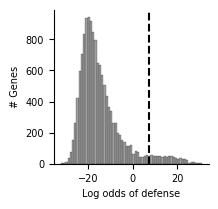

In [60]:
plt.subplots(figsize=(2,2))
sns.histplot(non_redundant_predictions['log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hit_distribution_nr.svg', dpi=300, bbox_inches='tight')

In [61]:
filtered_nr_predictions = non_redundant_predictions[non_redundant_predictions['log_odds'] > med_log_odds_cutoff].copy()
filtered_nr_predictions['accession_stub'] = (filtered_nr_predictions['product_accession']
                                          .str.split('.', expand=True)[0])
filtered_nr_predictions['hit_category'] = filtered_nr_predictions['hit_category'].cat.remove_unused_categories()

In [62]:
filtered_nr_predictions['hit_category'].value_counts()/len(filtered_nr_predictions)

hit_category
Defense homolog in new context        0.409207
Predicted novel defense gene          0.300512
Defense homolog in expected system    0.181586
Remote defense homolog                0.108696
Name: count, dtype: float64

In [63]:
filtered_nr_predictions['hit_category'].value_counts()

hit_category
Defense homolog in new context        320
Predicted novel defense gene          235
Defense homolog in expected system    142
Remote defense homolog                 85
Name: count, dtype: int64

In [64]:
non_redundant_predictions['defense_system_protein'].sum()

161

In [65]:
non_redundant_predictions.loc[(non_redundant_predictions['log_odds'] <= med_log_odds_cutoff) & 
            (non_redundant_predictions['defense_system_protein']), 'defense_homolog_names'].value_counts()

defense_homolog_names
Shango__SngC, PsyrTA__PsyrT                               2
BstA__BstA                                                1
PD-T4-1__PD-T4-1                                          1
Gabija__GajB_2                                            1
BREX__pglW, Mokosh_TypeI__MkoA, PD-T4-6__PD-T4-6          1
RM_Type_II__Type_II_MTases                                1
BREX__brxHII, DISARM_1__drmD                              1
BREX__pglW, Mokosh_TypeI__MkoA2                           1
Mokosh_TypeI__MkoB2                                       1
PD-Lambda-5__PD-Lambda-5_B, RM_Type_II__Type_II_MTases    1
dGTPase__Sp_dGTPase                                       1
SoFic__SoFic                                              1
PD-T4-9__PD-T4-9_A                                        1
Mok_Hok_Sok__Hok                                          1
PD-T4-3__PD-T4-3                                          1
CBASS__Phospholipase                                      1
PD-Lambda-6__PD-La

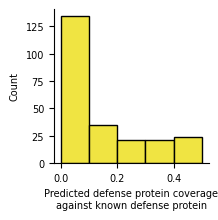

In [66]:
plt.subplots(figsize=(2,2))
sns.histplot(data=filtered_nr_predictions[filtered_nr_predictions['hit_category'] == 'Predicted novel defense gene'], 
             x='q_cov', binwidth=0.1, color='#f0e442', alpha=1)
plt.xlabel('Predicted defense protein coverage\nagainst known defense protein')
sns.despine()
#plt.savefig('../figures/novel_coverage.svg', dpi=300, bbox_inches='tight')

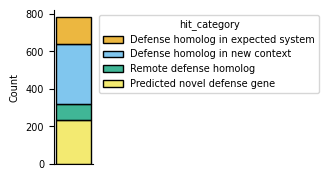

In [67]:
_, ax = plt.subplots(figsize=(0.5, 2))
ax = sns.histplot(data=filtered_nr_predictions, x=0, 
             hue='hit_category', 
             multiple='stack', 
             palette=bw_color_palette[:4], ax=ax, )
sns.move_legend(ax, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.xticks([])
plt.xlabel('')
plt.savefig('../figures/predicted_defense_known_frac_nr.svg', dpi=300, bbox_inches='tight')

In [68]:
nr_novel_accessions = filtered_nr_predictions.loc[filtered_nr_predictions['hit_category'] == 'Predicted novel defense gene', 
                                          'accession_stub'].drop_duplicates()
nr_novel_pfam_results = pfam_results[pfam_results['query'].isin(nr_novel_accessions)]
nr_novel_pfam_clans = (nr_novel_pfam_results[['query', 'clan_name']]
                    .drop_duplicates())

In [69]:
nr_select_novel_pfam_domains = select_domains(nr_novel_pfam_results)

100%|██████████| 179/179 [00:00<00:00, 635.30it/s]


In [70]:
(nr_select_novel_pfam_domains[['query','pfam_name', 'clan_name']].drop_duplicates()
 [['pfam_name', 'clan_name']]
 .value_counts()
 .head(20))

pfam_name       clan_name     
Mrr_cat_2       PDDEXK            6
DpnII-MboI      PDDEXK            6
RepB-RCR_reg    Met_repress       6
KAP_NTPase      P-loop_NTPase     4
NinG            His-Me_finger     4
HATPase_c_5     His_Kinase_A      3
IIGP            P-loop_NTPase     3
Dynamin_N       P-loop_NTPase     3
Response_reg_2  CheY              3
PDDEXK_4        PDDEXK            2
NucS_C          PDDEXK            2
Polbeta         NTP_transf        2
SLATT_4         SLATT             2
Metallophos_3   Calcineurin       2
UvrD-helicase   P-loop_NTPase     2
ICEA            His-Me_finger     2
Hjc             PDDEXK            2
HVO_2753_ZBP    Zn_Beta_Ribbon    2
HEPN_RiboL-PSP  KNTase_C          2
HEPN_Apea       KNTase_C          2
Name: count, dtype: int64

In [71]:
nr_novel_pfam_clan_count = (nr_select_novel_pfam_domains.groupby('clan_name')
                         .agg(count=('query', 'nunique'))
                         .rename(index={'P-loop_NTPase': 'P-loop NTPase', 
                                        'PDDEXK': 'PDDEXK nuclease', 
                                        'PEP-carboxyk': 'PEP carboxykinase',
                                        'Met_repress': 'RHH antitoxin DNA binding', 
                                        'KNTase_C': 'HEPN', 
                                        'His-Me_finger': 'HNH endonuclease', 
                                        'Zn_Beta_Ribbon': 'Zinc finger', 
                                        'His_Kinase_A': 'His kinase phospho-acceptor'})
                         .sort_values('count', ascending=False)
                         .reset_index())
nr_novel_pfam_clan_count['freq'] = nr_novel_pfam_clan_count['count']/len(nr_novel_accessions)

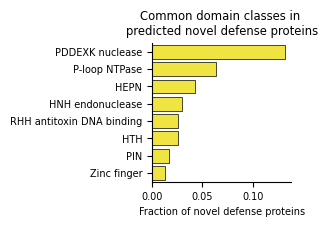

In [72]:
plt.subplots(figsize=(1.8,1.8))
sns.barplot(data=nr_novel_pfam_clan_count.head(8), y='clan_name', x='freq', 
            color=bw_color_palette[3], linewidth=0.5, edgecolor='black', saturation=100)
sns.despine()
plt.xlabel('Fraction of novel defense proteins')
plt.ylabel('')
plt.title('Common domain classes in \npredicted novel defense proteins')
plt.savefig('../figures/predicted_novel_defense_domains_nr.svg', dpi=300, bbox_inches='tight')

In [73]:
nr_novel_pfam_clan_count.head(8)

,clan_name,count,freq
0,PDDEXK nuclease,31,0.131915
1,P-loop NTPase,15,0.063830
2,HEPN,10,0.042553
3,HNH endonuclease,7,0.029787
4,RHH antitoxin DNA binding,6,0.025532
5,HTH,6,0.025532
6,PIN,4,0.017021
7,Zinc finger,3,0.012766


In [74]:
novel_cluster_known_domains_n = novel_genes_known_domains['cluster_id'].nunique()

In [75]:
novel_cluster_known_domains_n

129

In [76]:
len(nr_novel_accessions)

235

In [77]:
novel_cluster_known_domains_n/len(nr_novel_accessions)

0.548936170212766

In [78]:
non_redundant_predictions

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,contig_end,cluster_id,MG1655_homolog,log_odds,pos_training_protein,pos_training_profile,hit_name,q_cov,Prob,hit_category
182728,WP_000249525.1|NZ_QOYI01000039.1|9828|+,1.000000e+00,CDS,with_protein,GCF_003333685.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYI01000039.1,9828,...,False,WP_000249525.1,False,30.993797,False,True,NaN,0.0,NaN,Defense homolog in expected system
178961,WP_087902712.1|NZ_QOXE01000049.1|17138|+,1.000000e+00,CDS,with_protein,GCF_003334165.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXE01000049.1,17138,...,False,WP_087902712.1,False,30.354985,False,True,NaN,0.0,NaN,Defense homolog in expected system
201971,WP_000025792.1|NZ_QOXQ01000010.1|141356|+,1.000000e+00,CDS,with_protein,GCF_003333945.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXQ01000010.1,141356,...,False,WP_000025792.1,False,28.623673,True,True,NaN,0.0,NaN,Defense homolog in expected system
166567,WP_087933569.1|NZ_QOWY01000003.1|330|-,1.000000e+00,CDS,with_protein,GCF_003334235.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOWY01000003.1,330,...,False,WP_087933569.1,False,28.354740,False,True,NaN,0.0,NaN,Defense homolog in expected system
192573,WP_042059558.1|NZ_QOXN01000003.1|145590|-,1.000000e+00,CDS,with_protein,GCF_003334015.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOXN01000003.1,145590,...,False,WP_042059558.1,False,28.007080,False,True,NaN,0.0,NaN,Defense homolog in expected system
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289805,WP_000467176.1|NZ_QOYY01000018.1|27475|-,5.179986e-14,CDS,with_protein,GCF_003333435.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYY01000018.1,27475,...,False,WP_000467180.1,True,-30.591389,False,False,NaN,0.0,NaN,Not defensive
163035,WP_000118626.1|NZ_RRWJ01000006.1|21157|-,4.873987e-14,CDS,with_protein,GCF_003892475.1,Primary Assembly,unplaced scaffold,NaN,NZ_RRWJ01000006.1,21157,...,False,WP_000118626.1,True,-30.652279,False,False,NaN,0.0,NaN,Not defensive
190584,WP_000401139.1|NZ_QOYB01000002.1|324976|+,2.880439e-14,CDS,with_protein,GCF_003333785.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYB01000002.1,324976,...,False,WP_087934936.1,True,-31.178249,False,False,NaN,0.0,NaN,Not defensive
256288,WP_000118512.1|NZ_QOYO01000001.1|308750|+,1.392887e-14,CDS,with_protein,GCF_003333605.1,Primary Assembly,unplaced scaffold,NaN,NZ_QOYO01000001.1,308750,...,False,WP_000118507.1,True,-31.904813,False,False,NaN,0.0,NaN,Not defensive


In [79]:
cluster_n_genomes = (predictions.groupby('cluster_id')
                     .agg(n_genomes=('assembly', 'nunique'))
                     .reset_index())
predicted_novel_defense_clusters = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                                          ['cluster_id']].drop_duplicates()
pnd_clusters_n_genomes = (predicted_novel_defense_clusters.merge(cluster_n_genomes, 
                                                                how='inner', on='cluster_id'))
pnd_clusters_n_genomes['category'] = 'Predicted novel\ndefense genes'
known_defense_clusters = predictions.loc[predictions['defense_system_protein'], 
                                         ['cluster_id']].drop_duplicates()
kd_clusters_n_genomes = (known_defense_clusters.merge(cluster_n_genomes, 
                                                      how='inner', on='cluster_id'))
kd_clusters_n_genomes['category'] = 'All defense homologs\nin expected systems'
cluster_n_genomes['category'] = 'All genes'
cluster_categories_n_genomes = pd.concat([cluster_n_genomes, pnd_clusters_n_genomes, kd_clusters_n_genomes], axis=0)
cluster_categories_n_genomes['category'] = pd.Categorical(cluster_categories_n_genomes['category'], 
                                                              categories=['All genes',
                                                                  'All defense homologs\nin expected systems',
                                                                'Predicted novel\ndefense genes'])

In [80]:
cluster_n_genomes = (predictions.groupby('cluster_id')
                     .agg(n_genomes=('assembly', 'nunique'))
                     .reset_index())
cluster_n_genomes['category'] = 'All protein clusters'
novel_clusters = non_redundant_predictions.loc[non_redundant_predictions["hit_category"] == 'Predicted novel defense gene', 
                                               'cluster_id']
novel_n_genomes = cluster_n_genomes[cluster_n_genomes['cluster_id'].isin(novel_clusters)].copy()
novel_n_genomes['category'] = 'Predicted novel defense'
known_clusters = non_redundant_predictions.loc[non_redundant_predictions["hit_category"] == 'Defense homolog in expected system', 
                                               'cluster_id']
known_n_genomes = cluster_n_genomes[cluster_n_genomes['cluster_id'].isin(known_clusters)].copy()
known_n_genomes['category'] = 'Defense homologs in expected system'
cluster_categories_n_genomes = pd.concat([cluster_n_genomes, novel_n_genomes, known_n_genomes], axis=0)
cluster_categories_n_genomes['category'] = pd.Categorical(cluster_categories_n_genomes['category'], 
                                                              categories=['All protein clusters',
                                                                  'Defense homologs in expected system',
                                                                'Predicted novel defense'])

In [81]:
cluster_categories_n_genomes['accessory_gene'] = cluster_categories_n_genomes['n_genomes'] <= 5

In [82]:
(cluster_categories_n_genomes.groupby('category')
 .agg(frac_accessory=('accessory_gene', lambda x: x.sum()/len(x))))

,frac_accessory
category,
All protein clusters,0.551757
Defense homologs in expected system,0.726708
Predicted novel defense,0.910638


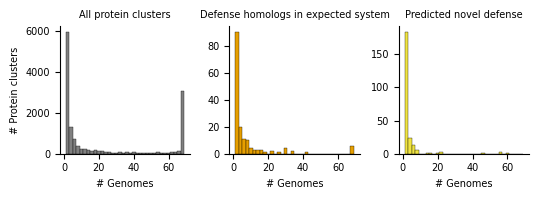

In [83]:
g = sns.displot(data=cluster_categories_n_genomes, x='n_genomes', binwidth=2, 
                hue='category', palette=(['grey', '#e69f00', '#f0e442']), 
                col='category', kind='hist', facet_kws={'sharey': False}, 
                alpha=1, height=2, legend=False, aspect=0.9)
g.set_titles(template='{col_name}')
g.set_xlabels('# Genomes')
g.set_ylabels('# Protein clusters')
g.figure.subplots_adjust(wspace=0.3)
plt.savefig('../figures/cluster_distribution.svg', dpi=300, bbox_inches='tight')

In [85]:
nr_select_novel_pfam_domains.to_csv('../data/interim/ecor_unique_novel_pfam_domains.csv', index=False)

In [89]:
nr_novel_predictions = non_redundant_predictions[non_redundant_predictions['hit_category'] == 'Predicted novel defense gene']

In [91]:
nr_novel_predictions.to_csv('../data/interim/ecor_unique_novel_proteins.csv', index=False)